In [1]:
!pip install opencv-python
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

You should consider upgrading via the 'pip install --upgrade pip' command.


## copy and paste

In [2]:
background_img_path = "1_background.jpg"
source_img_path = "1_source.jpg"
mask_path = '1_mask.png'

# start position in the background
x_start = 300
y_start = 300

In [3]:
def resize(img, mask, scale=1.0, style='Image'):
    """
    helper function if you need to resize the source image
    style can be "Image" which assumes to be RGB image 
              or "OpenCV" which assumes to be BGR image
    """
    if style == 'Image':
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    w, h, c = foreground_image.shape
    w = int(w*scale)
    h = int(h*scale)
    resize_img = cv2.resize(img, (h, w))
    resize_mask = cv2.resize(mask, (h, w))
    if style == 'Image':
        resize_img = cv2.cvtColor(resize_img, cv2.COLOR_BGR2RGB)
    return resize_img, resize_mask

In [4]:
# load background image, source image, mask
background_img = np.array(Image.open(background_img_path).convert('RGB'))
source_img = np.array(Image.open(source_img_path).convert('RGB'))
mask = np.array(Image.open(mask_path))
# uncomment the following line to resize source image and mask
# source_img, mask = resize(source_img, mask, 0.8)
mask = mask > 0
source_obj = np.zeros((source_img.shape[0], source_img.shape[1], 3))
for i in range(3):
    source_obj[:,:,i] = source_img[:,:,i] * mask

# create canvas source image and canvas mask
canvas_source_img = np.zeros((background_img.shape))
canvas_source_img[x_start:source_obj.shape[0]+x_start, y_start:source_obj.shape[1]+y_start] = source_obj
canvas_mask = np.zeros((background_img.shape[0], background_img.shape[1]))
canvas_mask[x_start:source_obj.shape[0]+x_start, y_start:source_obj.shape[1]+y_start] = mask

Without the background, we can see how the target image will look like the result. The mask is an array full of 0 and 1. 1 indicates it is part of the target object. 

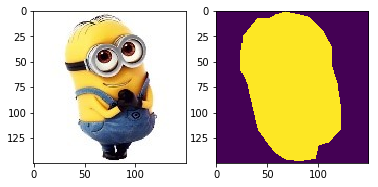

In [5]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(source_img)
ax[1].imshow(mask)

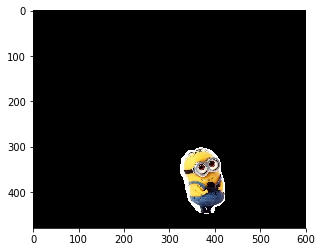

In [6]:
plt.imshow(canvas_source_img / 255)
plt.show()

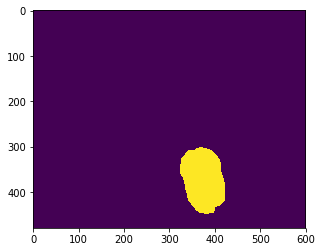

In [7]:
plt.imshow(canvas_mask)
plt.show()

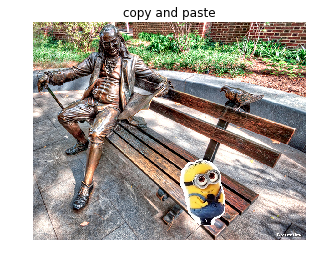

In [8]:
# directly copy and paste
mask_source = canvas_mask
mask_target = 1 - mask_source
            
output_img = np.zeros((background_img.shape))
source_image = canvas_source_img
target_image = background_img
source_mask = mask_source
target_mask = mask_target
    
# TODO: complete the image copy and paste
for i in range(3):
    output_img[:,:,i] = source_image[:,:,i] * source_mask + target_image[:,:,i] * target_mask

plt.figure()
plt.imshow(output_img/255)
plt.axis('off')
plt.title('copy and paste')
plt.imsave('copy_paste_output.jpg', output_img/255)

## alpha blending
The idea of alpha blending is to use a new channel $\alpha$ besides normal RGB channel to encode transparency. $\alpha = 1$ means the object is opaque and $\alpha=0$ means the object is transparent. To do the blending, we make both the source image and the target image transparent at the blending area and mix them together:
$$I_{blend} = \alpha * I_{source} + (1 - \alpha) * I_{target}$$

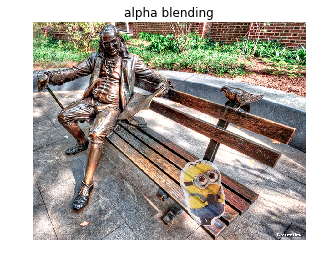

In [9]:
# alpha blending
alpha = 0.7

# TODO: complete the alpha blending
for i in range(3):
    # in the source_mask area, take alpha * source + (1 - alpha) * target
    # in the target_mask = 1 - source_mask area, take the target image
    output_img[:,:,i] = source_image[:,:,i]*source_mask*alpha + target_image[:,:,i]*source_mask*(1-alpha) + target_image[:,:,i]*target_mask

plt.figure()
plt.imshow(output_img/255)
plt.axis('off')
plt.title('alpha blending')
plt.imsave('alpha_blending.jpg', (output_img/255).astype('uint8'))

## feathering
An improvement to alpha blending is to change the alpha from the boundary to the center of the object. 
![img](feathering.png)
From the boundary to the center, the alpha value changes from 0 to 1.
At the blending area, two alpha values of two images come across each other and form a window
![img](feathering2.png)

In [10]:
# creating graduately changing alpha mask
b = np.ones_like(mask, dtype=np.uint8)
w_size = 60
size = b.shape[0] // 2 - w_size
b[b.shape[0]//2-size:b.shape[0]//2+size, b.shape[1]//2-size:b.shape[1]//2+size]=0
dist = cv2.distanceTransform(b, cv2.DIST_L2, cv2.DIST_MASK_3)
alpha_mask = np.zeros((background_img.shape[0], background_img.shape[1]))
m_dist = 1 - dist / dist.max()
alpha_mask[x_start:source_obj.shape[0]+x_start, y_start:source_obj.shape[1]+y_start] = m_dist

Alpha mask changes from 1 in the center to 0 at the boundary. Brighter the color larger the value.

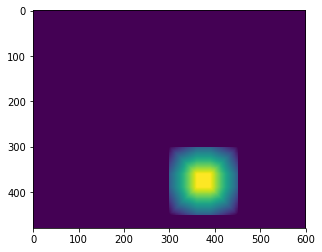

In [11]:
plt.imshow(alpha_mask)

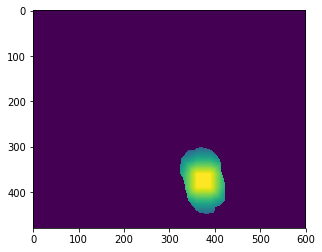

In [12]:
plt.imshow(source_mask*alpha_mask)

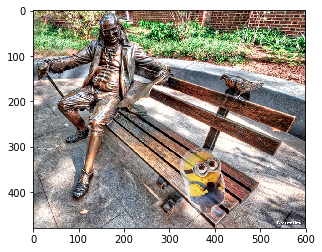

In [13]:
output_img = np.zeros((background_img.shape))
for i in range(3):
    # in the source_mask area, take alpha * source + (1 - alpha) * target
    # in the target_mask = 1 - source_mask area, take the target image
    output_img[:,:,i] = source_image[:,:,i]*source_mask*alpha_mask + target_image[:,:,i]*source_mask*(1-alpha_mask)+ target_image[:,:,i]*target_mask
plt.imshow(output_img / 255)   
    

## Gradient blending
We know that abrupt gradient change results in edges. Humans are good at detecting edges. When it comes to image blending, these edges become noticable seams that make people feel the blended image is not real. To overcome this, gradient blending tries to match the gradient of two images smoothly.
![img](gradient.png)
![img](gradient2.png)
To do this, gradient blending reconsturct pixels in the blending area with optimization method. 
The object is to make the gradient of the reconstructed area(area filled with yellow dots) close to the gradient of the source image while keeping boundary pixels(blue dots) unchanged from the target image. 
![img](gradient3.png)

In [14]:
foreground_mask = mask.astype(np.uint8) * 255

In [15]:
# p is the posiiton of the center of the source image instead of the top left corner as before
p = (x_start + source_img.shape[1]//2, y_start + source_img.shape[0]//2)

In [16]:
blended_image = cv2.seamlessClone(source_img, background_img, foreground_mask, p, cv2.NORMAL_CLONE)

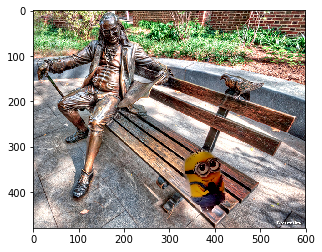

In [17]:
plt.imshow(blended_image)

Typically, the color of the background will be blended into the source image with gradient blending. 